In [98]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statistics import mean
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [99]:
# DATAPATH = "/kaggle/input/store-sales-time-series-forecasting"
DATAPATH = "data/store-sales"
FIGSIZE = (14, 4)

In [100]:
train_df = pd.read_csv(DATAPATH + '/train.csv', parse_dates=['date'])
test_df = pd.read_csv(DATAPATH + '/test.csv', parse_dates=['date'])

stores_df = pd.read_csv(DATAPATH + '/stores.csv')
stores_df = stores_df.rename(columns={'type': 'store_type'})

transactions_df = pd.read_csv(DATAPATH + '/transactions.csv', parse_dates=['date'])
oil_df = pd.read_csv(DATAPATH + '/oil.csv', parse_dates=['date'])

holidays_df = pd.read_csv(DATAPATH + '/holidays_events.csv', parse_dates=['date'])

In [101]:
def remove_outliers(df):
    for istore in range(len(df.store_nbr.unique())):  # handling the ouliers for each store
        val = df[df.store_nbr == istore].sales.quantile(0.99)
        df = df.drop(df[(df.store_nbr == istore) & (df.sales > val)].index)

    return df


train_df = remove_outliers(train_df)

In [102]:
def assign_time_ft(df):
    df['month_end'] = df['date'].dt.is_month_end.astype(int)
    df['payday'] = ((df['date'].dt.day == 15) | df['date'].dt.is_month_end).astype(int)

    df["dayofyear"] = df['date'].dt.dayofyear

    df["weekofyear"] = df['date'].dt.isocalendar().week
    df['weekofyear'] = df['weekofyear'].astype(np.int32)

    df['weekday'] = df['date'].dt.weekday
    df['quarter'] = df['date'].dt.quarter
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

    df['is_weekday'] = 0
    df.loc[df['weekday'] < 5, 'is_weekday'] = 1

    df["season"] = df["month"] % 12 // 3
    return df


train_df = assign_time_ft(train_df)
test_df = assign_time_ft(test_df)

In [103]:
def preprocess_oil(oil):
    oil['month'] = oil['date'].dt.month
    oil['month_avg'] = oil.groupby('month')['dcoilwtico'].transform('mean')

    oil['tmp'] = oil['dcoilwtico'].map(np.isnan)
    oil['month_avg'] = oil['tmp'] * oil['month_avg']
    oil['month_avg'] = oil['month_avg'].astype(float)

    oil['dcoilwtico'].fillna(0, inplace=True)
    oil['dcoilwtico'] = oil['dcoilwtico'] + oil['month_avg']

    oil = oil.drop(['month', 'month_avg', 'tmp'], axis=1)

    return oil


oil_df = preprocess_oil(oil_df)

In [104]:
def preprocess_holiday(df):
    filtered_holiday = df[(df['transferred'] == False) & (df['type'] != 'Work Day')]

    event = df[df['type'] == 'Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi') == False]

    return filtered_holiday, event, earthquake


filtered_df, event_df, earthquake_df = preprocess_holiday(holidays_df)

In [105]:
event_df = event_df[['date', 'description']]
event_df.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake_df = earthquake_df[['date', 'description']]
earthquake_df.rename({'description': 'earthquake'}, axis=1, inplace=True)

In [106]:
h_local = filtered_df[filtered_df['locale'] == 'Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_hname'}, axis=1)

h_regional = filtered_df[filtered_df['locale'] == 'Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_hname'}, axis=1)

h_national = filtered_df[filtered_df['locale'] == 'National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_hname'}, axis=1)

In [107]:
def merge_tables(df):
    df = df.merge(oil_df, on='date', how='left')
    df = df.merge(stores_df, on='store_nbr', how='left')

    df = df.merge(event_df, on='date', how='left')
    df = df.merge(earthquake_df, on='date', how='left')
    df = df.merge(h_local, on=['date', 'city'], how='left')
    df = df.merge(h_regional, on=['date', 'state'], how='left')
    df = df.merge(h_national, on='date', how='left')

    df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')

    return df


train_df = merge_tables(train_df)
test_df = merge_tables(test_df)

In [108]:
del h_local, h_regional, h_national, earthquake_df, event_df, stores_df, oil_df, filtered_df, transactions_df

In [109]:
def handle_na(df):
    obj_vals = ['event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']
    df[obj_vals] = df[obj_vals].fillna('0')

    return df


train_df = handle_na(train_df)
test_df = handle_na(test_df)

In [110]:
encode_cols = ['family', 'store_nbr', 'city', 'state', 'store_type', 'cluster',
               'event_name', 'earthquake', 'local_hname', 'regional_hname', 'national_hname']

lb = LabelEncoder()

for c in encode_cols:
    train_df[c] = lb.fit_transform(train_df[c])
    test_df[c] = lb.transform(test_df[c])

In [111]:
all_data = pd.concat([train_df, test_df])

In [112]:
def lag_ft(df):
    new_df = df.copy()

    targets = ['sales', 'dcoilwtico', 'transactions']
    keys = ['store_nbr', 'family']
    lag_values = [16, 21, 30, 45, 60, 90, 120, 365]

    for target in targets:
        for lag in lag_values:
            new_df[target + '_lag_' + str(lag)] = new_df.groupby(keys)[target].shift(lag)

    return new_df


all_data = lag_ft(all_data)

In [113]:
def optimize_mem(df, for_int=False):
    cols = list(df.columns)

    if 'date' in cols:
        cols.remove('date')

    df[cols] = df[cols].apply(pd.to_numeric, downcast="float")

    down_target = "integer" if for_int else "unsigned"
    df[cols] = df[cols].apply(pd.to_numeric, downcast=down_target)

    return df


all_data = optimize_mem(all_data)

In [114]:
def create_rolling_ft(new_df):
    targets = ['sales']
    rollings = [20, 30, 45, 60, 90, 120, 365]

    shift_df = pd.DataFrame()

    for target in targets:
        print(f'Creating {target} features')
        grouped = new_df.groupby(["store_nbr", "family"])[target]

        for rollval in rollings:
            results = {}

            avg_roll = grouped.rolling(rollval).mean()
            max_roll = grouped.rolling(rollval).max()
            min_roll = grouped.rolling(rollval).min()

            results[f"SMA{str(rollval)}_{target}_lag16_avg"] = avg_roll.shift(16).values
            results[f"SMA{str(rollval)}_{target}_lag16_max"] = max_roll.shift(16).values
            results[f"SMA{str(rollval)}_{target}_lag16_min"] = min_roll.shift(16).values

            results[f"SMA{str(rollval)}_{target}_lag30_avg"] = avg_roll.shift(30).values
            results[f"SMA{str(rollval)}_{target}_lag30_max"] = max_roll.shift(30).values
            results[f"SMA{str(rollval)}_{target}_lag30_min"] = min_roll.shift(30).values

            results[f"SMA{str(rollval)}_{target}_lag60_avg"] = avg_roll.shift(60).values
            results[f"SMA{str(rollval)}_{target}_lag60_max"] = max_roll.shift(60).values
            results[f"SMA{str(rollval)}_{target}_lag60_min"] = min_roll.shift(60).values

            result_df = pd.DataFrame.from_dict(results)
            shift_df = pd.concat([shift_df, result_df], axis=1)

        shift_df = optimize_mem(shift_df)

    return shift_df


sort_df = all_data.sort_values(["store_nbr", "family", "date"])
res_df = create_rolling_ft(sort_df)
all_data = all_data.join(res_df)

Creating sales features


In [115]:
del sort_df

In [116]:
def create_exp_mov_av(df):
    targets = ['sales', 'dcoilwtico', 'transactions']
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    lags = [16, 30, 60, 90]

    ewm_df = pd.DataFrame()

    for target in targets:
        grouped = df.groupby(["store_nbr", "family"])[target]
        for alpha in alphas:
            for lag in lags:
                results = {
                    f'{target}_ewm_alpha_{str(alpha).replace(".", "")}_lag_{str(lag)}': grouped.shift(lag)
                    .ewm(alpha=alpha).mean()
                }
                result_df = pd.DataFrame.from_dict(results)
                ewm_df = pd.concat([ewm_df, result_df], axis=1)

    return ewm_df


res_df = create_exp_mov_av(all_data)
all_data = all_data.join(res_df)
all_data = all_data.sort_values(['id'])

In [117]:
del res_df

In [118]:
all_data = all_data.fillna(0)
all_data = optimize_mem(all_data, for_int=True)

In [119]:
def split_dfs(df):
    new_train = df.iloc[:train_df.shape[0], :]
    new_test = df.iloc[train_df.shape[0]:, :]

    return new_train, new_test


train_df, test_df = split_dfs(all_data)

In [120]:
del all_data

## Training

In [121]:
xgb_params = {
    'n_estimators': 75,
    'importance_type': 'gain',
    'verbosity': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    'random_state': 42,
    'early_stopping_rounds': 25
}

In [122]:
split_size = 0.85
drop_cols = ['id', 'date', 'sales']  # maybe dcoilwtico

In [123]:
def train_model(train, y):
    temp_train = train.copy()

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=15))
    ])

    temp_train = pipeline.fit_transform(temp_train)

    x_tr, x_v, y_tr, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = xgb.XGBRegressor(**xgb_params)
    trained_model = model.fit(x_tr, y_tr, eval_set=[(x_v, y_v)])

    return trained_model, x_v, y_v, pipeline

In [124]:
def train_model_gridcv(train, y):
    temp_train = train.copy()

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=15))
    ])

    temp_train = pipeline.fit_transform(temp_train)

    grid_params = {
        'max_depth': [3, 6, 8, 10],
        'n_estimators': [50, 75, 100],
        'subsample': [1, 0.8, 0.75],
        'learning_rate': [0.3, 0.03, 0.003],
    }

    scoring = {
        "mae": make_scorer(mean_absolute_error),
        "rmsle": make_scorer(mean_squared_log_error),
        "r2": make_scorer(r2_score)
    }

    _, x_v, _, y_v = train_test_split(temp_train, y, train_size=split_size, random_state=42, shuffle=False)

    model = xgb.XGBRegressor(importance_type='gain', verbosity=1, eval_metric='rmse',
                             objective='reg:squarederror', random_state=42)

    clf = GridSearchCV(model, grid_params, refit='r2', scoring=scoring, verbose=1, n_jobs=1, cv=3)
    clf.fit(temp_train, y)

    print(clf.best_score_)
    print(clf.best_params_)

    return clf.best_estimator_, x_v, y_v, pipeline

In [125]:
y_train = np.log1p(train_df['sales'])
x_train = train_df.drop(drop_cols, axis=1)
single_features = x_train.columns

single_model, x_val, y_val, single_pipe = train_model(x_train, y_train)

[0]	validation_0-rmse:3.04381
[1]	validation_0-rmse:2.50339
[2]	validation_0-rmse:2.13209
[3]	validation_0-rmse:1.92494
[4]	validation_0-rmse:1.79738
[5]	validation_0-rmse:1.70670
[6]	validation_0-rmse:1.66910
[7]	validation_0-rmse:1.63702
[8]	validation_0-rmse:1.61125
[9]	validation_0-rmse:1.59807
[10]	validation_0-rmse:1.58997
[11]	validation_0-rmse:1.58700
[12]	validation_0-rmse:1.58212
[13]	validation_0-rmse:1.57427
[14]	validation_0-rmse:1.56757
[15]	validation_0-rmse:1.56130
[16]	validation_0-rmse:1.55803
[17]	validation_0-rmse:1.55530
[18]	validation_0-rmse:1.55676
[19]	validation_0-rmse:1.55533
[20]	validation_0-rmse:1.55529
[21]	validation_0-rmse:1.55360
[22]	validation_0-rmse:1.55083
[23]	validation_0-rmse:1.54646
[24]	validation_0-rmse:1.54386
[25]	validation_0-rmse:1.54188
[26]	validation_0-rmse:1.53754
[27]	validation_0-rmse:1.53657
[28]	validation_0-rmse:1.53579
[29]	validation_0-rmse:1.53372
[30]	validation_0-rmse:1.53230
[31]	validation_0-rmse:1.53185
[32]	validation_0-

In [126]:
def show_metrics(actual, predictions, mdict):
    mae = mean_absolute_error(actual, predictions)
    mse = mean_squared_error(actual, predictions, squared=True)
    rmsle = mean_squared_log_error(actual, predictions)
    r2 = r2_score(actual, predictions)

    print("\nRegression metrics")
    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('RMSLE: {:.2f}'.format(rmsle))
    print('R2: {:.2f}'.format(r2))

    if mdict is not None:
        mdict["mae"].append(mae)
        mdict["mse"].append(mse)
        mdict["rmsle"].append(rmsle)
        mdict["r2"].append(r2)

In [127]:
print(f"\nEvaluating model")
y_pred = single_model.predict(x_val)
y_pred[y_pred < 0] = 0
y_pred = np.expm1(y_pred)
y_pred[y_pred < 0] = 0

y_actual = np.expm1(y_val)

show_metrics(y_actual, y_pred, None)


Evaluating model

Regression metrics
MAE: 150.63
MSE: 169235.44
RMSLE: 2.24
R2: 0.83


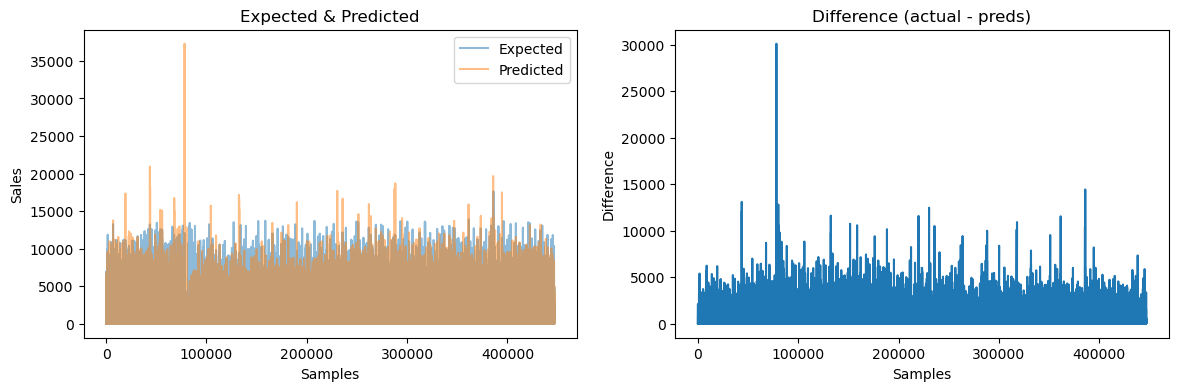

In [128]:
%matplotlib inline

def plot_predictions(nb_samples, actual, predictions):
    sp_list = list(range(0, nb_samples))

    plt.figure(figsize=FIGSIZE)
    plt.subplot(1, 2, 1)
    plt.plot(sp_list, actual, label='Expected', alpha=0.5)
    plt.plot(sp_list, predictions, label='Predicted', alpha=0.5)
    plt.legend(loc="upper right")
    plt.title('Expected & Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Sales')

    plt.subplot(1, 2, 2)
    plt.plot(sp_list, abs(actual - predictions))
    plt.title('Difference (actual - preds)')
    plt.xlabel('Samples')
    plt.ylabel('Difference')

    plt.show()


plot_predictions(len(x_val), y_actual, y_pred)
plt.show()

In [129]:
if not single_pipe:  # if pca is applied, can't use this
    feature_names = [x for x in train_df.columns if x not in drop_cols]
    features_val = single_model.feature_importances_

    plt.figure(figsize=FIGSIZE)
    ft = pd.Series(features_val, index=feature_names)

    nb_elem = 25
    top_features = ft.nlargest(nb_elem, keep='all').sort_values(ascending=True)
    top_features.plot.barh()

    plt.show()

    print('Features not shown\n', list(ft.index.difference(top_features.index)))

In [130]:
s_v = train_df['store_nbr'].unique()
shop_nbr = len(s_v)
shop_preprocess = [None] * shop_nbr
shop_models = [None] * shop_nbr

shop_drop_cols = drop_cols.copy()
shop_drop_cols.append('store_nbr')

dropped_df = train_df.drop(shop_drop_cols, axis=1)
shop_features = dropped_df.columns

In [131]:
metrics_dict = {"mae": [], "mse": [], "rmsle": [], "r2": []}

for shop in range(shop_nbr):
    shop_df = train_df[train_df.store_nbr == shop]
    shop_y = np.log1p(shop_df['sales'])

    print(f"Training model {shop}...")
    shopmodel, x_val, y_val, pipe = train_model(shop_df[shop_features], shop_y)

    shop_preprocess[shop] = pipe

    print(f"\nEvaluating sub-model {shop}")
    y_pred = shopmodel.predict(x_val)
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0

    shop_models[shop] = shopmodel

    y_actual = np.expm1(y_val)
    show_metrics(y_actual, y_pred, metrics_dict)

Training model 0...
[0]	validation_0-rmse:2.84124
[1]	validation_0-rmse:2.25492
[2]	validation_0-rmse:1.89323
[3]	validation_0-rmse:1.67787
[4]	validation_0-rmse:1.54888
[5]	validation_0-rmse:1.47371
[6]	validation_0-rmse:1.43128
[7]	validation_0-rmse:1.40634
[8]	validation_0-rmse:1.38831
[9]	validation_0-rmse:1.37657
[10]	validation_0-rmse:1.36998
[11]	validation_0-rmse:1.36244
[12]	validation_0-rmse:1.35904
[13]	validation_0-rmse:1.35708
[14]	validation_0-rmse:1.35812
[15]	validation_0-rmse:1.35903
[16]	validation_0-rmse:1.36058
[17]	validation_0-rmse:1.36024
[18]	validation_0-rmse:1.36163
[19]	validation_0-rmse:1.36116
[20]	validation_0-rmse:1.36133
[21]	validation_0-rmse:1.36202
[22]	validation_0-rmse:1.36177
[23]	validation_0-rmse:1.36227
[24]	validation_0-rmse:1.36216
[25]	validation_0-rmse:1.36472
[26]	validation_0-rmse:1.36456
[27]	validation_0-rmse:1.36806
[28]	validation_0-rmse:1.36571
[29]	validation_0-rmse:1.36650
[30]	validation_0-rmse:1.36450
[31]	validation_0-rmse:1.3644

In [132]:
print(f"\nBy shop training summary")
for mkey, mval in metrics_dict.items():
    print("Average {} : {:.2f}".format(mkey.upper(), mean(mval)))


By shop training summary
Average MAE : 136.87
Average MSE : 153731.70
Average RMSLE : 2.08
Average R2 : 0.82


In [133]:
f_v = train_df['family'].unique()
family_nbr = len(f_v)
family_preprocess = [None] * family_nbr
family_models = [None] * family_nbr

fam_drop_cols = drop_cols.copy()
fam_drop_cols.append('family')

dropped_df = train_df.drop(fam_drop_cols, axis=1)
fam_features = dropped_df.columns

In [134]:
metrics_dict = {"mae": [], "mse": [], "rmsle": [], "r2": []}

for fam in range(family_nbr):
    fam_df = train_df[train_df.family == fam]
    family_y = np.log1p(fam_df['sales'])

    print(f"Training model {fam}...")
    fammodel, x_val, y_val, pipe = train_model(fam_df[fam_features], family_y)

    family_preprocess[fam] = pipe

    print(f"\nEvaluating sub-model {fam}")
    y_pred = fammodel.predict(x_val)
    y_pred[y_pred < 0] = 0
    y_pred = np.expm1(y_pred)
    y_pred[y_pred < 0] = 0

    family_models[fam] = fammodel

    y_actual = np.expm1(y_val)
    show_metrics(y_actual, y_pred, metrics_dict)

Training model 0...
[0]	validation_0-rmse:1.21995
[1]	validation_0-rmse:0.97079
[2]	validation_0-rmse:0.81760
[3]	validation_0-rmse:0.72357
[4]	validation_0-rmse:0.66894
[5]	validation_0-rmse:0.64251
[6]	validation_0-rmse:0.62538
[7]	validation_0-rmse:0.61518
[8]	validation_0-rmse:0.60891
[9]	validation_0-rmse:0.60623
[10]	validation_0-rmse:0.60444
[11]	validation_0-rmse:0.60291
[12]	validation_0-rmse:0.60259
[13]	validation_0-rmse:0.60214
[14]	validation_0-rmse:0.60207
[15]	validation_0-rmse:0.60163
[16]	validation_0-rmse:0.60175
[17]	validation_0-rmse:0.60156
[18]	validation_0-rmse:0.60170
[19]	validation_0-rmse:0.60151
[20]	validation_0-rmse:0.60168
[21]	validation_0-rmse:0.60172
[22]	validation_0-rmse:0.60198
[23]	validation_0-rmse:0.60199
[24]	validation_0-rmse:0.60185
[25]	validation_0-rmse:0.60177
[26]	validation_0-rmse:0.60207
[27]	validation_0-rmse:0.60165
[28]	validation_0-rmse:0.60168
[29]	validation_0-rmse:0.60181
[30]	validation_0-rmse:0.60171
[31]	validation_0-rmse:0.6013

In [135]:
print(f"\nBy family training summary")
for mkey, mval in metrics_dict.items():
    print("Average {} : {:.2f}".format(mkey.upper(), mean(mval)))


By family training summary
Average MAE : 110.14
Average MSE : 163596.66
Average RMSLE : 0.61
Average R2 : 0.47


## Submissions

In [136]:
def make_predictions(s_model, test_data, features, pipeline=None):
    pred_df = pd.DataFrame()
    id_df = pd.DataFrame()

    df = test_data[features]

    if pipeline is not None:
        df = pipeline.transform(df)

    xgb_pred = pd.Series(s_model.predict(df, iteration_range=(0, s_model.best_iteration)))

    pred_df['sales'] = np.expm1(xgb_pred.map(lambda x: max(x, 0)))
    pred_df['sales'][pred_df['sales'] < 0] = 0

    id_df['id'] = test_data['id'].copy()
    id_df.reset_index(drop=True, inplace=True)
    pred_df['id'] = id_df['id']

    return pred_df

In [137]:
def zero_unused_families(df_preds, test_data):
    df_zeros = train_df.groupby(["store_nbr", "family"]).sales.sum().reset_index()
    df_zeros = df_zeros[df_zeros.sales == 0]

    temp_df = test_data.copy()
    temp_df['sales'] = df_preds['sales']
    zeroed_df = pd.merge(temp_df, df_zeros, left_on=['store_nbr', 'family'], right_on=['store_nbr', 'family'],
                         how='left')
    zeroed_df.loc[zeroed_df['sales_y'] == 0, 'sales_x'] = zeroed_df['sales_y']

    zeroed_df.rename(columns={'sales_x': 'sales'}, inplace=True)
    zeroed_df = zeroed_df.drop('sales_y', axis=1)
    return zeroed_df[['id', 'sales']]

In [138]:
single_preds = make_predictions(single_model, test_df, single_features, single_pipe)
single_preds = zero_unused_families(single_preds, test_df)

In [139]:
merged_df = pd.DataFrame()

for i in range(shop_nbr):
    shop_data = test_df[test_df.store_nbr == i]
    preds_df = make_predictions(shop_models[i], shop_data, shop_features, shop_preprocess[i])
    preds_df = zero_unused_families(preds_df, shop_data)
    merged_df = pd.concat([merged_df, preds_df])

store_preds = merged_df.sort_values('id', ascending=True)
store_preds = store_preds.reset_index(drop=True)

In [140]:
merged_df = pd.DataFrame()

for i in range(family_nbr):
    fam_data = test_df[test_df.family == i]
    preds_df = make_predictions(family_models[i], fam_data, fam_features, family_preprocess[i])
    preds_df = zero_unused_families(preds_df, fam_data)
    merged_df = pd.concat([merged_df, preds_df])

family_preds = merged_df.sort_values('id', ascending=True)
family_preds = family_preds.reset_index(drop=True)

In [141]:
submission = store_preds  # family_preds or store_preds or single_preds
submission.to_csv('submission.csv', index=False)

print('Submission saved')


Submission saved
